In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Finding duplicates


In [2]:
import random

X = 1000
D = 500

queries = ['x%i' % i for i in range(X)] + ['d%i' % (i%D) for i in range(2*D)]
print(D/len(queries))
#queries

0.25


In [3]:
sample = [query for query in queries if random.random() < 0.1]
#sample

In [4]:
from collections import Counter

def duplicates(queries):
    counts = Counter(queries)
    dupes = []
    for query,count in counts.items():
        if count > 1:
            dupes.append(query)
    return len(dupes)

print(D/(10*X + 19*D)) # from maths
duplicates(sample) / len(sample)

0.02564102564102564


0.0048543689320388345

In [5]:
# sample users, not queries
# pick a fraction (say one tenth) of users and collect all their queries
import string

X = 1000
D = 500
U = 50

queries = []

for u in range(U):
    # our users need a name!
    name = ''.join([random.choice(string.ascii_letters) for _ in range(10)])
    queries.extend([(name, 'x%i' % i) for i in range(X)] +
                   [(name, 'd%i' % (i%D)) for i in range(2*D)])

random.shuffle(queries)
queries[:30] # 30 random (user, query) pairs

[('mmnSewhxJR', 'x709'),
 ('rhfByriwTG', 'x271'),
 ('JwXmMdeCOb', 'd210'),
 ('teESXZTKMA', 'x581'),
 ('IypiDJuvns', 'x831'),
 ('iXSbaNZSEC', 'd199'),
 ('nJMUnFKVif', 'x191'),
 ('doqqJXggZR', 'x594'),
 ('SBPodUNRxQ', 'x798'),
 ('hWVmbOojLy', 'd40'),
 ('ZEkJkZxJkS', 'x736'),
 ('nbjtTzPbyf', 'd361'),
 ('ovSRuvVDeW', 'x930'),
 ('zLQNBJVoOB', 'd482'),
 ('TypTsNzcie', 'd101'),
 ('nbjtTzPbyf', 'd424'),
 ('TypTsNzcie', 'd364'),
 ('jvHkNmUXoL', 'd324'),
 ('gfdgxhhHjE', 'd94'),
 ('ctHfeMQCUb', 'x553'),
 ('ctHfeMQCUb', 'x418'),
 ('FUDKxFiFPB', 'd140'),
 ('APLdgTIPUT', 'x889'),
 ('mmnSewhxJR', 'x295'),
 ('teESXZTKMA', 'd395'),
 ('vjHLNmxAvC', 'd489'),
 ('SBPodUNRxQ', 'd185'),
 ('doqqJXggZR', 'x482'),
 ('IypiDJuvns', 'd200'),
 ('vjHLNmxAvC', 'x203')]

## Hash functions

We need a way to map from a username to some kind of numerical ID.
How do we do this? Especially if we don't know how many users there are? Need a function
that maps arbitrary inputs to a defined range of integers.

In [6]:
from sklearn.utils import murmurhash3_32

# python's builtin hash function isn't even approximately random
def hash_(n, seed=1):
    return murmurhash3_32(n, seed=seed, positive=True)

print(hash_("tim"), hash_("jim"), hash_("fred"), hash_("joe"))

2095282958 2892697151 374763764 1284432482


`hash_(item)` produces a 'random' number between `0` and `2**32-1`
the output is uniformly distributed and the same input will always produce the same output. Designing hash functions could be the topic of a whole lecture ... let's just assume they work and are a piece of magic handed down to us.

In [7]:
# hash name into ten buckets, pick all users that fall into bucket 1

sample = []
for (user, query) in queries:
    if (hash_(user) % 10) == 0:
        sample.append((user,query))
    
duplicates(sample) / len(sample)

0.25

In [8]:
# the bucket will contain approximately five users
set([x[0] for x in sample])

{'JwXmMdeCOb',
 'NBvsidKvsr',
 'YrFfTKatNa',
 'ZDNvLVFGYi',
 'eyjfYtwvsS',
 'zLQNBJVoOB'}

## Approximate answers

Often approximate answers are plenty good enough. Especially if you can compute a bound on the size of the mistake. And even more so if the alternative is getting no answer because your data is infinite!

Approximate is different from random subsampling:

In [9]:
x = [random.randint(0, 2e9) for _ in range(5000)]

y = [i>>8 for i in x]

In [10]:
# remove the last 8bits from the integers
bin(x[0])

'0b111100110000110000001011010001'

In [11]:
bin(x[0]>>8), bin(x[0])[:-8]

('0b1111001100001100000010', '0b1111001100001100000010')

In [12]:
(x[0], x[0]>>8)

(1019413201, 3982082)

In [13]:
mean_x = sum(x) / len(x)
mean_y = sum(y) / len(y) * 2**8

# compare the two answers and the fractional difference between the two
print(mean_x, mean_y, 100*(mean_x-mean_y)/mean_x)

1013177229.9822 1013177102.1824 1.261376551470496e-05


## Coin flips

You can estimate the number of times someone flipped a coin by keeping track of the longest run of "heads":

In [14]:
def generate_coinflips(num):
    return [random.choice([0, 1]) for i in range(num)]

def longest_run_zero(x):
    i = 0
    count = 0
    max_count = 0
    while i < len(x):
        if x[i] == 0:
            count += 1
        else:
            if count > max_count:
                max_count = count
            count = 0
        i += 1
        
    return max_count


def longest_run_mc(flips, repeats):
    z = []
    for i in range(repeats):
        x = generate_coinflips(flips)
        count = longest_run_zero(x)
        z.append(count)
        
    return z

6.643856189774725


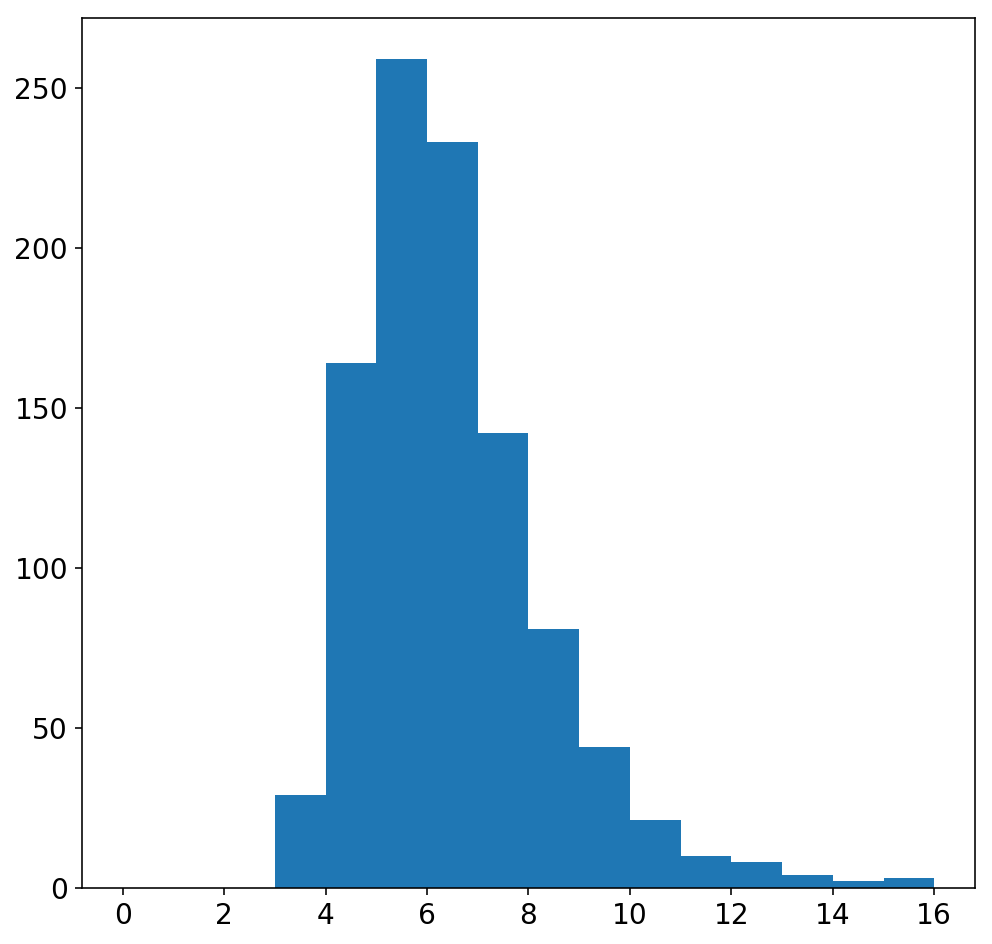

In [15]:
d = longest_run_mc(100, 1000)
plt.hist(d, bins=max(d), range=(0, max(d)))

import math
# we expect a peak right around...
print(math.log(100, 2))

8.965784284662087


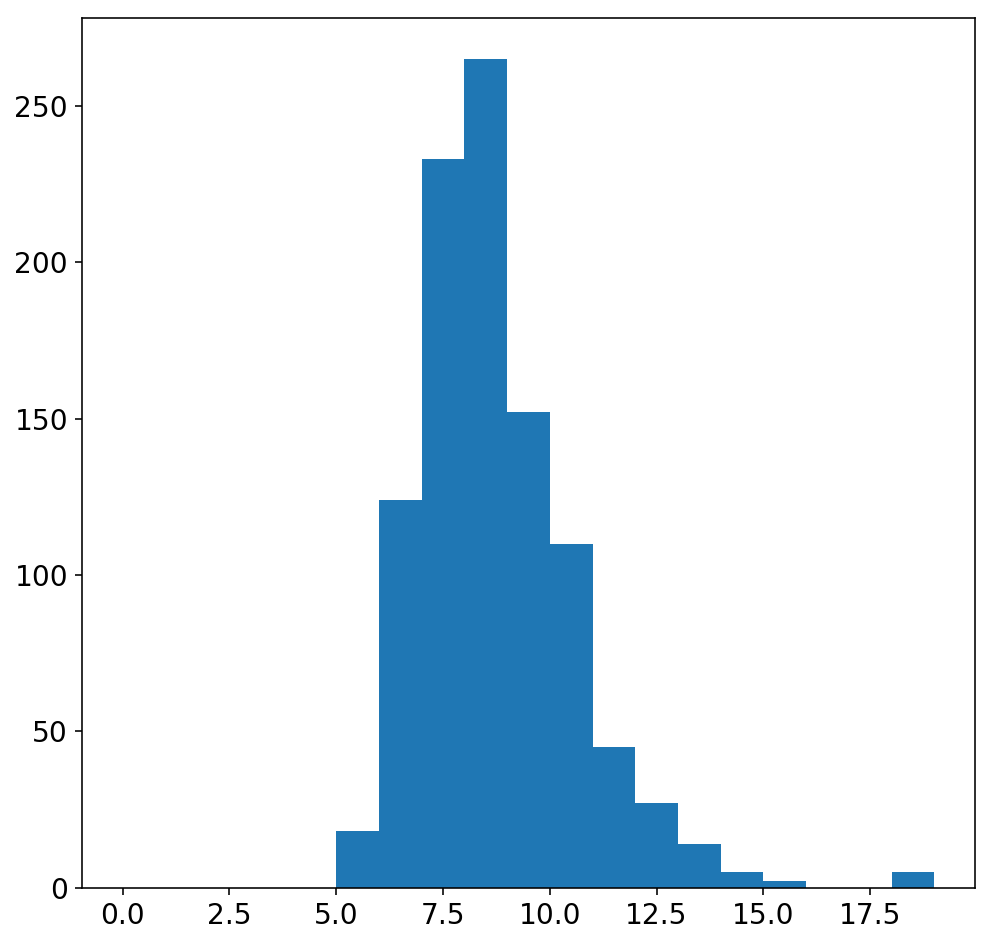

In [16]:
# flip 500 times in a row
d = longest_run_mc(500, 1000)
plt.hist(d, bins=max(d), range=(0, max(d)))

import math
# we expect a peak right around...
print(math.log(500, 2))